In [1]:
import glob
import numpy as np
import hyss_util as hu
from datetime import datetime
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from plotting import set_defaults
import pandas as pd
from scipy.optimize import minimize
import random
from sklearn.model_selection import train_test_split
import emcee
import corner
from IPython.display import display, Math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# -- set the types

kind = "bld"
comp = "bld"
runpca = False
runfan = False
runica = False
getndvi = False

In [3]:
# -- get wavelengths
waves = hu.read_header("../../../image_files/veg_00000.hdr")["waves"]

# -- define good scans
good = np.array([int(i) for i in np.load("../../../gdobler_output/output/good_scans.npy")])

reading and parsing ../../../image_files/veg_00000.hdr...


In [4]:
# -- load the comparison set
print("getting {0} spectra...".format(comp))
try:
    blds = np.load("../../../gdobler_output/output/blds_right.npy")
except:
    blds = np.array([np.load(i)[:,:,78:].mean(-1).mean(-1) for i in
                     sorted(glob.glob("../../../gdobler_output/output/{0}_specs/{0}_specs*.npy"\
                                          .format(comp))) if "_avg" not in i])
    blds = blds[good]
    # np.save("../output/blds_right.npy",blds)

getting bld spectra...


In [5]:
# -- normalize spectra
ms, bs = [], []
for ii in range(blds.shape[0]):
    # m, b = np.polyfit(blds[ii,:100],blds[0,:100],1)
    # m, b = np.polyfit(blds[ii],blds[0],1)
    m = blds[0].mean()/blds[ii].mean()
    b = 0.0
    ms.append(m)
    bs.append(b)

ms   = np.array(ms)
bs   = np.array(bs)
norm = blds*ms[:,np.newaxis] + bs[:,np.newaxis]
rat  = norm/norm[0]

In [6]:
# -- get comparison spectra
print("getting {0} spectra...".format(comp))
try:
    vegs = np.load("../../../gdobler_output/output/blds_left.npy")
except:
    vegs = np.array([np.load(i)[:,:,:78].mean(-1).mean(-1) for i in
                     sorted(glob.glob("../../../gdobler_output/output/{0}_specs/{0}_specs*.npy"\
                                          .format(comp))) if "_avg" not in i])
    vegs = vegs[good]
    # np.save("../../../gdobler_output/output/blds_left.npy",vegs)

getting bld spectra...


In [7]:
# -- normalize spectra
ss, os = [], []
for ii in range(vegs.shape[0]):
    # s, o = np.polyfit(vegs[ii,:100],vegs[0,:100],1)
    # s, o = np.polyfit(vegs[ii],vegs[0],1)
    s = vegs[0].mean()/vegs[ii].mean()
    o = 0.0
    ss.append(s)
    os.append(o)

ss    = np.array(ss)
os    = np.array(os)
vnorm = vegs*ss[:,np.newaxis] + os[:,np.newaxis]
vrat  = vnorm/vnorm[0]

In [8]:
# -- take the ratio of ratios
brat = vrat/rat

In [9]:
# -- get some ancillary data
sc     = pd.read_csv("../../../gdobler_output/output/scan_conditions.csv")
sc_sub = sc[sc.filename.isin(["veg_{0:05}.raw".format(i) for i in good])]

temps = sc_sub.temperature.values
humid = sc_sub.humidity.values
pm25  = sc_sub.pm25.values
o3    = sc_sub.o3.values
secs  = []
for stime in sc_sub.time.values:
    yr, mo, dy, tm = stime.split()
    stime_fmt      = "{0} {1} {2:02} {3}:00".format(yr,mo,int(dy),tm)
    obs_dt         = datetime.strptime(stime_fmt,"%Y %b %d %H:%M:%S")
    secs.append(float(obs_dt.strftime("%s")))
secs = np.array(secs)

In [10]:
# -- PCA
if runpca:
    print("running PCA...")
    pca = PCA(n_components=6)
    pca.fit(vrat/rat)
    pamps = pca.transform(vrat/rat)

# -- Factor Analysis
if runfan:
    print("running Factor Analysis...")
    fan = FactorAnalysis(n_components=6)
    fan.fit(vrat/rat)
    famps = fan.transform(vrat/rat)

# -- ICA
if runica:
    print("running ICA...")
    ica = FastICA(n_components=6)
    ica.fit(vrat/rat)
    iamps = ica.transform(vrat/rat)

# -- get NDVI
if getndvi:
    print("calculating NDVI...")
    print("  getting sky spectra...")
    flist   = sorted(glob.glob("../../../gdobler_output/output/sky_specs/*.npy"))
    skys    = np.array([np.load(i) for i in flist])[good]
    print("  getting reflectance...")
    ref     = (vegs - vegs.min(1,keepdims=True))/ \
        (skys-skys.min(1,keepdims=True))
    ind_ir  = np.argmin(np.abs(waves-860.))
    ind_vis = np.argmin(np.abs(waves-670.))
    print("  generating NDVI...")
    ndvi    = (ref[:,ind_ir]-ref[:,ind_vis]) / \
        (ref[:,ind_ir]+ref[:,ind_vis])

In [11]:
print(waves[500], waves[-150])
print(waves[430], waves[570])

ind_ir  = np.argmin(np.abs(waves-860.))
ind_vis = np.argmin(np.abs(waves-670.))

749.76 895.9
698.89 801.05


In [12]:
# calculate differential ratios

D_750_1000 = brat[:,500] / brat[:,-1]
D_750_900 = brat[:,500] / brat[:,-150]
D_750_900m1000 = brat[:,500] / (brat[:,-150:].mean(1))
D_700m800_900m1000 = (brat[:,430:570].mean(1)) / (brat[:,-150:].mean(1))
D_700m900_400m700 = (brat[:,424:-150].mean(1)) / (brat[:,:424].mean(1))
D_700m1000_400m700 = (brat[:,424:-1].mean(1)) / (brat[:,:424].mean(1))

In [13]:
# create air quality arrays

aq_opth1  = np.vstack([o3,pm25,temps,humid,np.ones_like(o3)]).T
aq_pth1 = np.vstack([pm25,temps,humid,np.ones_like(o3)]).T
aq_op1 = np.vstack([o3,pm25,np.ones_like(o3)]).T

## Linear Least Squares - no errors

### (1)  D(750) / D(1000)   --||vs||--   O3, PM2.5, Temps, Humid

In [14]:
ind  = np.arange(len(D_750_1000))
sol1  = np.linalg.lstsq(aq_opth1[ind],D_750_1000[ind], rcond=None)
pred1 = np.dot(aq_opth1[ind],sol1[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol1[1] / (len(D_750_1000) * D_750_1000.var())
print("sol = ", sol1)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([-7.40637461e-01,  2.08025765e-04,  6.00040385e-05, -2.97902062e-04,
        1.05367086e+00]), array([1.3524249]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.04550206]


### (2)  D(750) / D(900)   --||vs||--   O3, PM2.5, Temps, Humid

In [15]:
ind  = np.arange(len(D_750_900))
sol2  = np.linalg.lstsq(aq_opth1[ind],D_750_900[ind], rcond=None)
pred2 = np.dot(aq_opth1[ind],sol2[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol2[1] / (len(D_750_900) * D_750_900.var())
print("sol = ", sol2)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([-6.24096627e-01,  1.94828950e-04,  8.15609963e-05, -2.25950394e-04,
        1.04208861e+00]), array([1.01086002]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.04048883]


### (3)  D(750) / D(900-1000)   --||vs||--   O3, PM2.5, Temps, Humid

In [16]:
ind  = np.arange(len(D_750_900m1000))
sol3  = np.linalg.lstsq(aq_opth1[ind],D_750_900m1000[ind], rcond=None)
pred3 = np.dot(aq_opth1[ind],sol3[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol3[1] / (len(D_750_900m1000) * D_750_900m1000.var())
print("sol = ", sol3)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([-7.05895617e-01,  1.84783781e-04,  6.31809097e-05, -2.74043970e-04,
        1.05220610e+00]), array([1.26124251]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.04385909]


### (4)  D(700-800) / D(900-1000)   --||vs||--   O3, PM2.5, Temps, Humid

In [17]:
ind  = np.arange(len(D_700m800_900m1000))
sol4  = np.linalg.lstsq(aq_opth1[ind],D_700m800_900m1000[ind], rcond=None)
pred4 = np.dot(aq_opth1[ind],sol4[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol4[1] / (len(D_700m800_900m1000) * D_700m800_900m1000.var())
print("sol = ", sol4)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([-6.56165823e-01,  1.86188495e-04,  3.10819456e-05, -2.71438648e-04,
        1.05369847e+00]), array([1.01764356]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.04906051]


### (5)  D(700-900) / D(400-700)   --||vs||--   O3, PM2.5, Temps, Humid

In [18]:
ind  = np.arange(len(D_700m900_400m700))
sol5  = np.linalg.lstsq(aq_opth1[ind],D_700m900_400m700[ind], rcond=None)
pred5 = np.dot(aq_opth1[ind],sol5[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol5[1] / (len(D_700m900_400m700) * D_700m900_400m700.var())
print("sol = ", sol5)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([1.89822419e-01, 8.79668309e-05, 2.18112554e-05, 9.89958786e-05,
       9.81790267e-01]), array([0.05217549]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.11118119]


### (6)  D(700-1000) / D(400-700)   --||vs||--   O3, PM2.5, Temps, Humid

In [19]:
ind  = np.arange(len(D_700m1000_400m700))
sol6  = np.linalg.lstsq(aq_opth1[ind],D_700m1000_400m700[ind], rcond=None)
pred6 = np.dot(aq_opth1[ind],sol6[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol6[1] / (len(D_700m1000_400m700) * D_700m1000_400m700.var())
print("sol = ", sol6)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([3.39089818e-01, 4.18950834e-05, 1.56304487e-05, 1.59104677e-04,
       9.69475651e-01]), array([0.17167207]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.09151923]


#### Plot all together

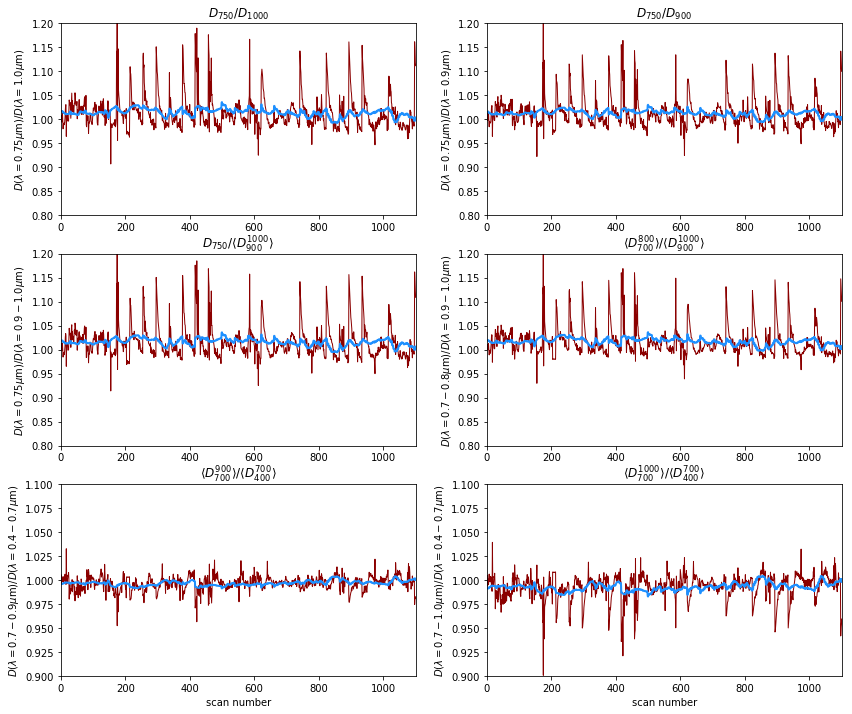

In [20]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

ax1.plot(D_750_1000,color="darkred",lw=1)
ax1.plot(pred1,color="dodgerblue",lw=2)
ax1.set_ylim(0.8,1.2)
ax1.set_xlim(0,pred1.size)
#ax1.set_xlabel("scan number")
ax1.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
ax1.set_title(r'$D_{750}/D_{1000}$')

ax2.plot(D_750_900,color="darkred",lw=1)
ax2.plot(pred2,color="dodgerblue",lw=2)
ax2.set_ylim(0.8,1.2)
ax2.set_xlim(0,pred2.size)
#ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=0.9\mu$m$)$')
ax2.set_title(r'$D_{750}/D_{900}$')

ax3.plot(D_750_900m1000,color="darkred",lw=1)
ax3.plot(pred3,color="dodgerblue",lw=2)
ax3.set_ylim(0.8,1.2)
ax3.set_xlim(0,pred3.size)
#ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax3.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=0.9-1.0\mu$m$)$')
ax3.set_title(r'$D_{750}/\langle D_{900}^{1000} \rangle$')

ax4.plot(D_700m800_900m1000,color="darkred",lw=1)
ax4.plot(pred4,color="dodgerblue",lw=2)
ax4.set_ylim(0.8,1.2)
ax4.set_xlim(0,pred4.size)
#ax4.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax4.set_ylabel(r'$D(\lambda=0.7-0.8\mu$m$)/D(\lambda=0.9-1.0\mu$m$)$')
ax4.set_title(r'$\langle D_{700}^{800} \rangle/\langle D_{900}^{1000} \rangle$')

ax5.plot(D_700m900_400m700,color="darkred",lw=1)
ax5.plot(pred5,color="dodgerblue",lw=2)
ax5.set_ylim(0.9,1.1)
ax5.set_xlim(0,pred5.size)
ax5.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax5.set_ylabel(r'$D(\lambda=0.7-0.9\mu$m$)/D(\lambda=0.4-0.7\mu$m$)$')
ax5.set_title(r'$\langle D_{700}^{900} \rangle/\langle D_{400}^{700} \rangle$')

ax6.plot(D_700m1000_400m700,color="darkred",lw=1)
ax6.plot(pred6,color="dodgerblue",lw=2)
ax6.set_ylim(0.9,1.1)
ax6.set_xlim(0,pred6.size)
ax6.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax6.set_ylabel(r'$D(\lambda=0.7-1.0\mu$m$)/D(\lambda=0.4-0.7\mu$m$)$')
ax6.set_title(r'$\langle D_{700}^{1000} \rangle/\langle D_{400}^{700} \rangle$')

plt.show()

## Maximum Likelihood Estimation with NDVI

$brightness = w_{O_3} * O_3 + w_{PM2.5} * PM2.5 + w_{temp} * temp + w_{humid} * humid + b + \epsilon$

$\epsilon$ is a Gaussian noise term such that:

observed = true + random.normal(0, $\epsilon$, number_of_observations)

In [21]:
# -- obtaining uncertainty for brightness
#brightness = brat[:,500]/brat[:,-1]
brightness = D_700m900_400m700
diff = brightness[1:] - brightness[:-1]
berr = diff.std()/np.sqrt(2.0)
print("error in NDVI = ", berr)

error in NDVI =  0.004619152300122581


In [22]:
# -- obtaining uncertainty for air quality
templates  = np.vstack([o3,pm25,temps,humid,np.ones_like(o3)]).T
diff_air = templates[1:] - templates[:-1]
air_err = diff_air.std(0)/np.sqrt(2.0)
print("errors in air qaulity = ", air_err)

errors in air qaulity =  [2.50960907e-03 7.69473073e-01 1.30383320e+00 2.97720678e+00
 0.00000000e+00]


In [23]:
brightness_err = np.full(brightness.shape, berr)
o3err = np.full(brightness.shape, air_err[0])
pm25err = np.full(brightness.shape, air_err[1])
temperr = np.full(brightness.shape, air_err[2])
humiderr = np.full(brightness.shape, air_err[3])
alphaerr = np.full(brightness.shape, air_err[4])
terr = np.vstack([o3err,pm25err,temperr,humiderr,alphaerr]).T

In [24]:
def log_prior(theta):
    beta_o3, beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    if eps <= 0:
        return -np.inf
    return 0.0

def log_likelihood(theta, o3, pm25, temps, humid, y):
    beta_o3, beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    model = beta_o3 * o3 + beta_pm25 * pm25 + beta_temps * temps + beta_humid * humid + alpha
    denom = eps ** 2
    lp = -0.5 * sum(((y - model) ** 2) / denom + np.log(denom) + np.log(2 * np.pi))
    return lp

def log_probability(theta, o3, pm25, temps, humid, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, o3, pm25, temps, humid, y)

In [26]:
# -- numerical optimum of likelihood function

from scipy.optimize import minimize

np.random.seed(314)
nll = lambda *args: -log_likelihood(*args)
initial = np.append(sol5[0], berr)
result = minimize(nll, initial, args=(templates[:,0], templates[:,1], templates[:,2], 
                                    templates[:,3], brightness))
beta_o3_ml, beta_pm25_ml, beta_temps_ml, beta_humid_ml, alpha_ml, epsilon_ml = result.x

print("Maximum likelihood estimates:")
print("w_o3    = {0:.5f}".format(beta_o3_ml))
print("w_pm25  = {0:.5f}".format(beta_pm25_ml))
print("w_temps = {0:.5f}".format(beta_temps_ml))
print("w_humid = {0:.5f}".format(beta_humid_ml))
print("b       = {0:.5f}".format(alpha_ml))
print("e       = {0:.5f}".format(epsilon_ml))

Maximum likelihood estimates:
w_o3    = 0.19021
w_pm25  = 0.00009
w_temps = 0.00002
w_humid = 0.00010
b       = 0.98185
e       = 0.00688


#### split sample into 80% training and 20% testing

In [28]:
from sklearn.model_selection import train_test_split

aq_tr, aq_te, br_tr, br_te = train_test_split(templates, brightness, test_size=0.2, random_state=314)

In [29]:
print("total # of instances: ", len(brightness))
print("# training instances: ", len(br_tr))
print("# testing instances : ", len(br_te))
print("# features (incl. 1): ", aq_tr.shape[1])

total # of instances:  1102
# training instances:  881
# testing instances :  221
# features (incl. 1):  5


## MCMC

$brightness = w_{O_3} * O_3 + w_{PM2.5} * PM2.5 + w_{temp} * temp + w_{humid} * humid + b + \epsilon$

$\epsilon$ is Gaussian noise term such that:

brightness observed = true brightness + random.normal(0, $\epsilon$, number_of_observations)

In [30]:
nwalkers, ndim = 50, 6
p0 = result.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [31]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(aq_tr[:,0],
                                                              aq_tr[:,1],
                                                              aq_tr[:,2],
                                                              aq_tr[:,3],
                                                              br_tr))
pos, prob, state = sampler.run_mcmc(p0, 5000)

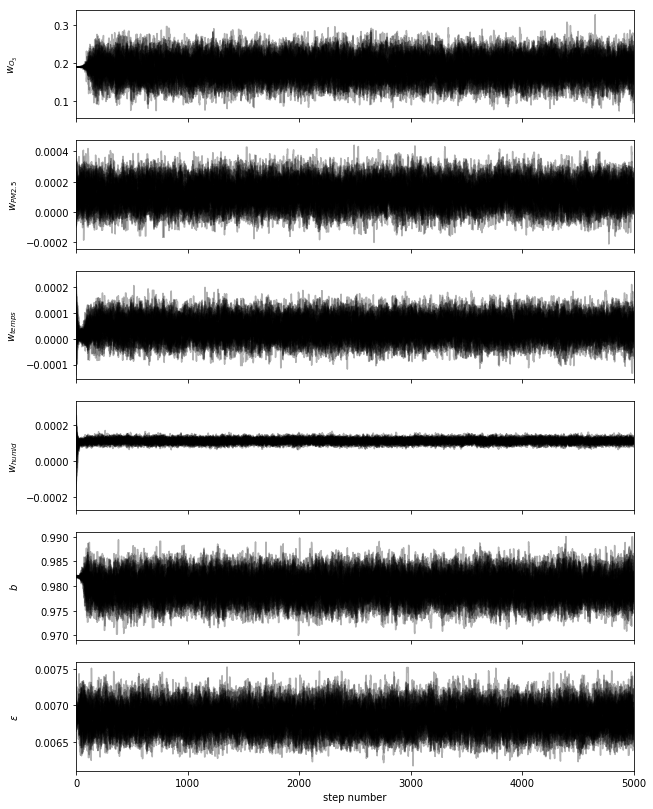

In [32]:
fig, axes = plt.subplots(ndim, figsize=(10, 14), sharex=True)
samples = sampler.get_chain()
labels = [r'$w_{O_3}$', r'$w_{PM2.5}$', r'$w_{temps}$', r'$w_{humid}$', r'$b$', r'$\epsilon$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number")
plt.show()

In [33]:
tau = sampler.get_autocorr_time()
print(tau)

[61.56216028 61.40461879 62.74238778 61.94640159 63.07250422 58.56201127]


In [34]:
# -- discard initial 200 steps (~3 x tau)
# -- thin by 30 (about half the autocorrelation time)
# -- flatten chain

flat_samples = sampler.get_chain(discard=200, thin=30, flat=True)
print(flat_samples.shape)

(8000, 6)


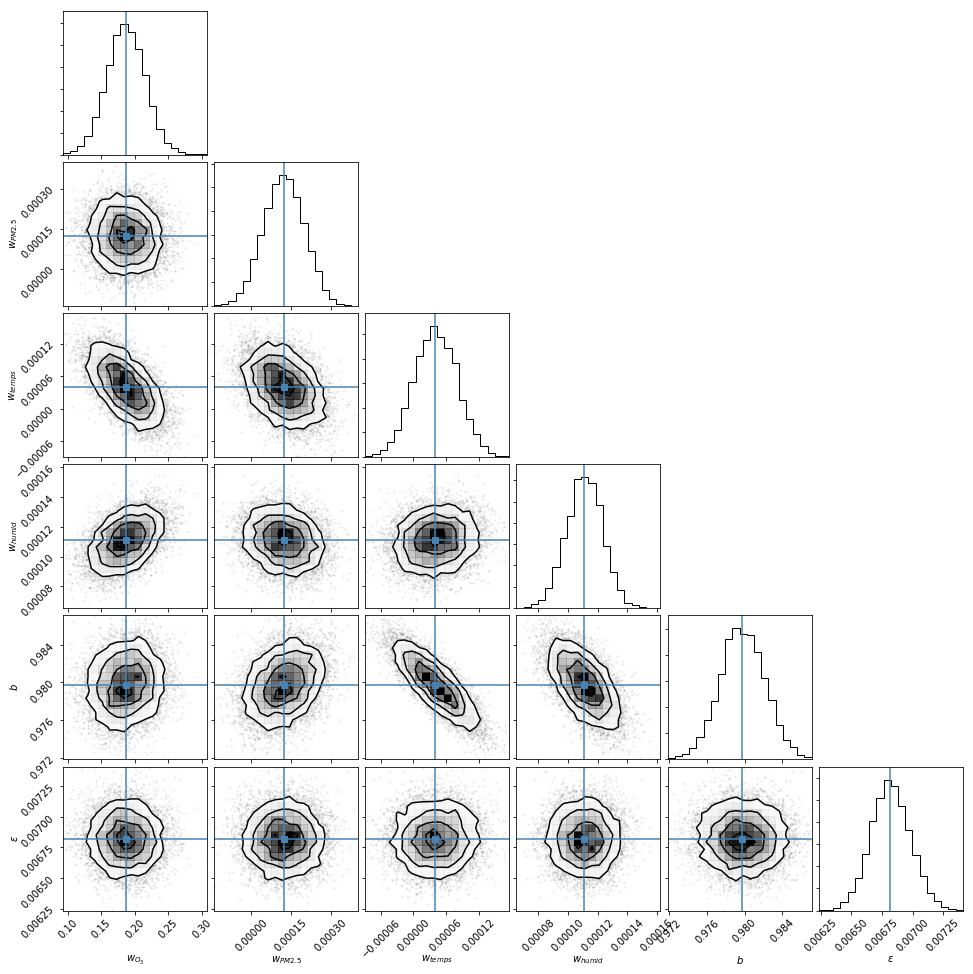

In [35]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=np.median(flat_samples, axis=0))

In [36]:
from IPython.display import display, Math

labels = ["m_{O_3}", "m_{PM2.5}", "m_{temps}", "m_{humid}", "b", "\epsilon"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

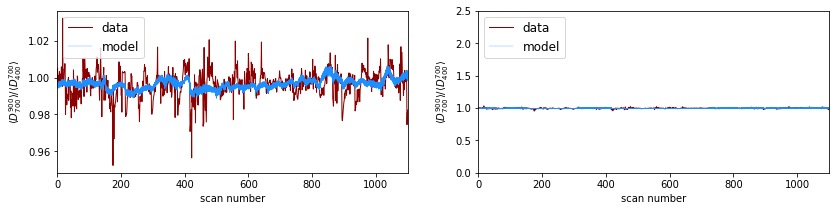

In [44]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=[13,3])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax1.plot(brightness,color="darkred",lw=1)
inds = np.random.randint(len(flat_samples), size=800)
for ind in inds:
    sample = flat_samples[ind]
    linp, = ax1.plot(np.dot(aq_opth1, sample[:5]), color="dodgerblue", lw=0.3)
#ax.set_ylim(0,2.5)
ax1.set_xlim(0,pred5.size)
ax1.set_xlabel("scan number")
ax1.set_ylabel(r'$\langle D_{700}^{900} \rangle/\langle D_{400}^{700} \rangle$')
ax1.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)

linb, = ax2.plot(brightness,color="darkred",lw=1)
inds = np.random.randint(len(flat_samples), size=800)
for ind in inds:
    sample = flat_samples[ind]
    linp, = ax2.plot(np.dot(aq_opth1, sample[:5]), color="dodgerblue", lw=0.3)
ax2.set_ylim(0,2.5)
ax2.set_xlim(0,pred5.size)
ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$\langle D_{700}^{900} \rangle/\langle D_{400}^{700} \rangle$')
ax2.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)


plt.show()

In [45]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals = np.zeros(6)
err_vals = np.zeros(6)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals[i] = mcmc[1]
    err_vals[i] = (abs(q[0]) + abs(q[1])) / 2

print(mvals)
print(err_vals)

[1.86746270e-01 1.22677886e-04 4.01876378e-05 1.11069730e-04
 9.79748374e-01 6.81852805e-03]
[2.85094497e-02 7.64417885e-05 3.97174277e-05 1.21335714e-05
 2.36865935e-03 1.60825801e-04]


In [46]:
# calculate prediction and uncertainty
pred_tr = np.dot(aq_tr, mvals[:5])
pred_te = np.dot(aq_te, mvals[:5])
pred_tr_err = np.zeros(pred_tr.shape)
pred_te_err = np.zeros(pred_te.shape)

def err_mult(m, merr, x, xerr):
    err = abs(m * x) * np.sqrt((merr/m)**2 + (xerr/x)**2)
    return err

for i in range(aq_tr.shape[0]):
    mO_err = err_mult(mvals[0], err_vals[0], aq_tr[i,0], air_err[0])
    mp_err = err_mult(mvals[1], err_vals[1], aq_tr[i,1], air_err[1])
    mt_err = err_mult(mvals[2], err_vals[2], aq_tr[i,2], air_err[2])
    mh_err = err_mult(mvals[3], err_vals[3], aq_tr[i,3], air_err[3])
    pred_tr_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals[4]]))

for i in range(aq_te.shape[0]):
    mO_err = err_mult(mvals[0], err_vals[0], aq_te[i,0], air_err[0])
    mp_err = err_mult(mvals[1], err_vals[1], aq_te[i,1], air_err[1])
    mt_err = err_mult(mvals[2], err_vals[2], aq_te[i,2], air_err[2])
    mh_err = err_mult(mvals[3], err_vals[3], aq_te[i,3], air_err[3])
    pred_te_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals[4]]))

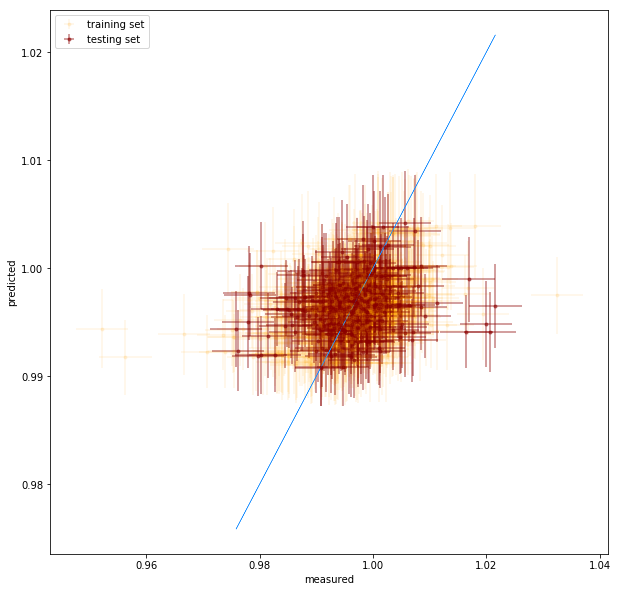

In [47]:
fig = plt.subplots(figsize=[10, 10])
linetr = plt.errorbar(br_tr, pred_tr, xerr=np.full(br_tr.shape, berr), 
                      yerr=pred_tr_err, fmt='.', color="orange", alpha=0.1)
linete = plt.errorbar(br_te, pred_te, xerr=np.full(br_te.shape, berr), 
                      yerr=pred_te_err, fmt='.', color="darkred", alpha=0.5)
linlin, = plt.plot(br_te, br_te, color="dodgerblue", lw=0.5)
plt.xlabel('measured')
plt.ylabel('predicted')
plt.legend([linetr,linete], ['training set', 'testing set'], loc='upper left')
plt.show()

#### reduced chi-squared per degree of freedom

In [48]:
def redchisqg(ydata, ymod, deg=2, sd=None):
    if np.any(sd == None):
        chisq = np.sum( (ydata-ymod)**2 )
    else:
        chisq = np.sum( ((ydata - ymod) / sd)**2 )
    
    # Number of degrees of freedom assuming 2 free parameters
    nu = ydata.size - deg
    
    return chisq/nu

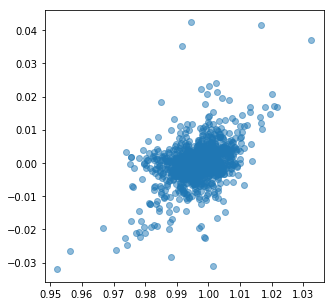

In [49]:
# -- obtaining uncertainties for measured

fig = plt.subplots(figsize=[5,5])
diff = brightness[1:] - brightness[:-1]
plt.plot(brightness[1:], diff, 'o', alpha=0.5)
plt.show()

In [50]:
berr = diff.std()/np.sqrt(2.0)
print("error in brightness = ", berr)

error in brightness =  0.004619152300122581


In [51]:
chisq_tr_opth = redchisqg(br_tr, pred_tr, deg=ndim-1, sd=np.full(br_tr.shape, berr))
chisq_te_opth = redchisqg(br_te, pred_te, deg=ndim-1, sd=np.full(br_te.shape, berr))

print("Training chi^2/dof = {0:.3f}".format(chisq_tr_opth))
print("Testing chi^2/dof  = {0:.3f}".format(chisq_te_opth))

Training chi^2/dof = 2.174
Testing chi^2/dof  = 2.527


# Without O3

In [52]:
aq_pth1 = np.vstack([pm25,temps,humid,np.ones_like(o3)]).T

In [54]:
ind  = np.arange(len(brightness))
sol  = np.linalg.lstsq(aq_pth1[ind],brightness[ind], rcond=None)
pred = np.dot(aq_pth1[ind],sol[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol[1] / (len(brightness) * brightness.var())
print("sol = ", sol)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([1.10850510e-04, 1.80091088e-04, 6.41495641e-05, 9.79911974e-01]), array([0.05476319]), 4, array([2958.97846333,  806.15043572,  103.97132823,    3.26923425]))
r2  =  [0.06709924]


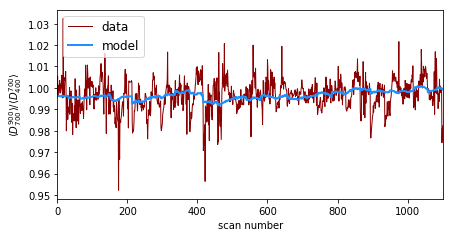

In [57]:
fig, ax = plt.subplots(figsize=[6.5,3.5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax.plot(brightness,color="darkred",lw=1)
linp, = ax.plot(pred,color="dodgerblue",lw=2)
#ax.set_ylim(0,2.5)
ax.set_xlim(0,pred.size)
ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax.set_ylabel(r'$\langle D_{700}^{900} \rangle/\langle D_{400}^{700} \rangle$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

## Maximum Likelihood Estimation with NDVI

$brightness = w_{PM2.5} * PM2.5 + w_{temp} * temp + w_{humid} * humid + b + \epsilon$

$\epsilon$ is a Gaussian noise term such that:

observed = true + random.normal(0, $\epsilon$, number_of_observations)

In [58]:
def log_prior(theta):
    beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    if eps <= 0:
        return -np.inf
    return 0.0

def log_likelihood(theta, pm25, temps, humid, y):
    beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    model = beta_pm25 * pm25 + beta_temps * temps + beta_humid * humid + alpha
    denom = eps ** 2
    lp = -0.5 * sum(((y - model) ** 2) / denom + np.log(denom) + np.log(2 * np.pi))
    return lp

def log_probability(theta, pm25, temps, humid, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, pm25, temps, humid, y)

In [60]:
# -- numerical optimum of likelihood function

from scipy.optimize import minimize

np.random.seed(314)
nll = lambda *args: -log_likelihood(*args)
initial = np.append(sol[0], berr)
result = minimize(nll, initial, args=(aq_pth1[:,0], aq_pth1[:,1], aq_pth1[:,2], brightness))
beta_pm25_ml, beta_temps_ml, beta_humid_ml, alpha_ml, epsilon_ml = result.x

print("Maximum likelihood estimates:")
print("w_pm25  = {0:.5f}".format(beta_pm25_ml))
print("w_temps = {0:.5f}".format(beta_temps_ml))
print("w_humid = {0:.5f}".format(beta_humid_ml))
print("b       = {0:.5f}".format(alpha_ml))
print("e       = {0:.5f}".format(epsilon_ml))

Maximum likelihood estimates:
w_pm25  = 0.00011
w_temps = 0.00018
w_humid = 0.00006
b       = 0.97997
e       = 0.00705


#### split sample into 80% training and 20% testing

In [61]:
from sklearn.model_selection import train_test_split

aq_tr, aq_te, br_tr, br_te = train_test_split(aq_pth1, brightness, test_size=0.2, random_state=314)

In [62]:
print("total # of instances: ", len(brightness))
print("# training instances: ", len(br_tr))
print("# testing instances : ", len(br_te))
print("# features (incl. 1): ", aq_tr.shape[1])

total # of instances:  1102
# training instances:  881
# testing instances :  221
# features (incl. 1):  4


## MCMC

$brightness = w_{PM2.5} * PM2.5 + w_{temp} * temp + w_{humid} * humid + b + \epsilon$

$\epsilon$ is Gaussian noise term such that:

brightness observed = true brightness + random.normal(0, $\epsilon$, number_of_observations)

In [63]:
nwalkers, ndim = 50, 5
p0 = result.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [64]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(aq_tr[:,0],
                                                              aq_tr[:,1],
                                                              aq_tr[:,2],
                                                              br_tr))
pos, prob, state = sampler.run_mcmc(p0, 5000)

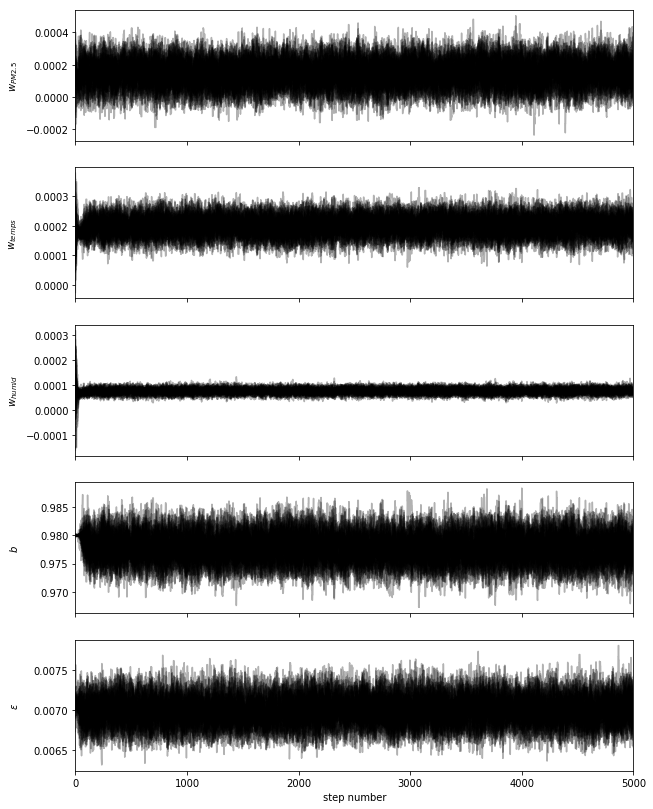

In [67]:
fig, axes = plt.subplots(ndim, figsize=(10, 14), sharex=True)
samples = sampler.get_chain()
labels = [r'$w_{PM2.5}$', r'$w_{temps}$', r'$w_{humid}$', r'$b$', r'$\epsilon$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number")
plt.show()

In [66]:
tau = sampler.get_autocorr_time()
print(tau)

[48.33434176 50.0353668  49.63188545 52.87795043 52.78156853]


In [68]:
# -- discard initial 200 steps (~3 x tau)
# -- thin by 30 (about half the autocorrelation time)
# -- flatten chain

flat_samples = sampler.get_chain(discard=150, thin=25, flat=True)
print(flat_samples.shape)

(9700, 5)


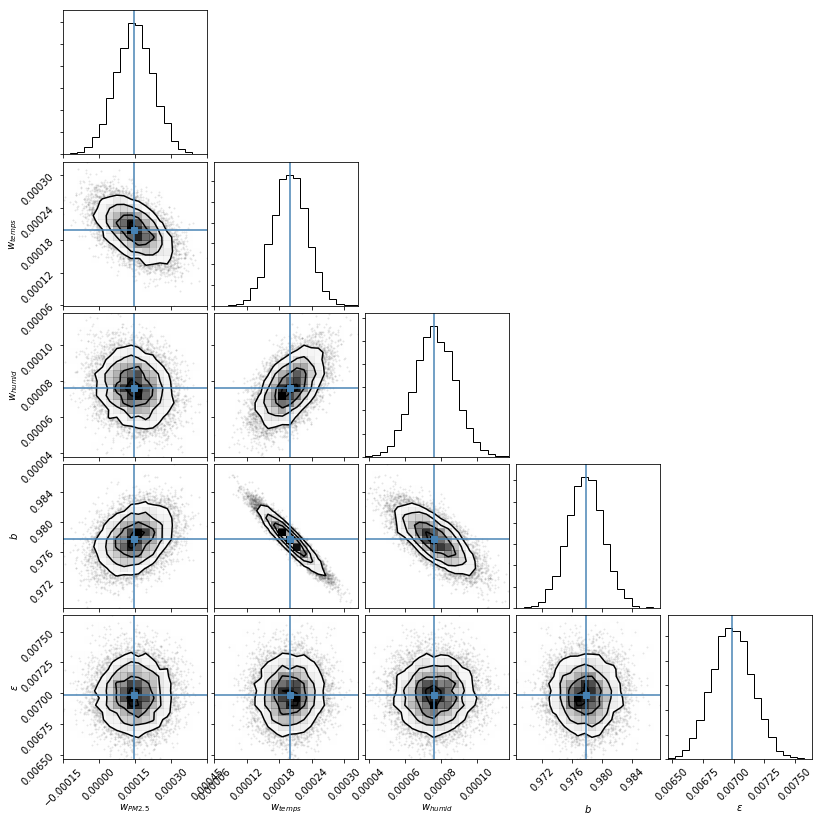

In [69]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=np.median(flat_samples, axis=0))

In [70]:
from IPython.display import display, Math

labels = ["m_{PM2.5}", "m_{temps}", "m_{humid}", "b", "\epsilon"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

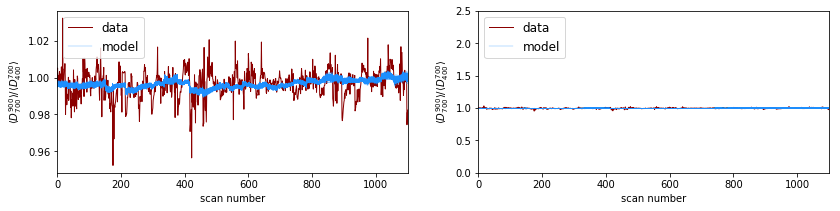

In [72]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=[13,3])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax1.plot(brightness,color="darkred",lw=1)
inds = np.random.randint(len(flat_samples), size=800)
for ind in inds:
    sample = flat_samples[ind]
    linp, = ax1.plot(np.dot(aq_pth1, sample[:4]), color="dodgerblue", lw=0.3)
#ax1.set_ylim(0,2.5)
ax1.set_xlim(0,pred.size)
ax1.set_xlabel("scan number")
ax1.set_ylabel(r'$\langle D_{700}^{900} \rangle/\langle D_{400}^{700} \rangle$')
ax1.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)

linb, = ax2.plot(brightness,color="darkred",lw=1)
inds = np.random.randint(len(flat_samples), size=800)
for ind in inds:
    sample = flat_samples[ind]
    linp, = ax2.plot(np.dot(aq_pth1, sample[:4]), color="dodgerblue", lw=0.3)
ax2.set_ylim(0,2.5)
ax2.set_xlim(0,pred.size)
ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$\langle D_{700}^{900} \rangle/\langle D_{400}^{700} \rangle$')
ax2.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

In [73]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals = np.zeros(5)
err_vals = np.zeros(5)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals[i] = mcmc[1]
    err_vals[i] = (abs(q[0]) + abs(q[1])) / 2

print(mvals)
print(err_vals)

[1.46534205e-04 1.99471390e-04 7.65013931e-05 9.77772897e-01
 6.98592816e-03]
[7.83765571e-05 3.10282219e-05 1.11138746e-05 2.34049206e-03
 1.65991229e-04]


In [75]:
# calculate prediction and uncertainty
pred_tr = np.dot(aq_tr, mvals[:4])
pred_te = np.dot(aq_te, mvals[:4])
pred_tr_err = np.zeros(pred_tr.shape)
pred_te_err = np.zeros(pred_te.shape)

def err_mult(m, merr, x, xerr):
    err = abs(m * x) * np.sqrt((merr/m)**2 + (xerr/x)**2)
    return err

for i in range(aq_tr.shape[0]):
    mp_err = err_mult(mvals[0], err_vals[0], aq_tr[i,0], air_err[0])
    mt_err = err_mult(mvals[1], err_vals[1], aq_tr[i,1], air_err[1])
    mh_err = err_mult(mvals[2], err_vals[2], aq_tr[i,2], air_err[2])
    pred_tr_err[i] = np.linalg.norm(np.array([mp_err, mt_err, mh_err, err_vals[3]]))

for i in range(aq_te.shape[0]):
    mp_err = err_mult(mvals[0], err_vals[0], aq_te[i,0], air_err[0])
    mt_err = err_mult(mvals[1], err_vals[1], aq_te[i,1], air_err[1])
    mh_err = err_mult(mvals[2], err_vals[2], aq_te[i,2], air_err[2])
    pred_te_err[i] = np.linalg.norm(np.array([mp_err, mt_err, mh_err, err_vals[3]]))

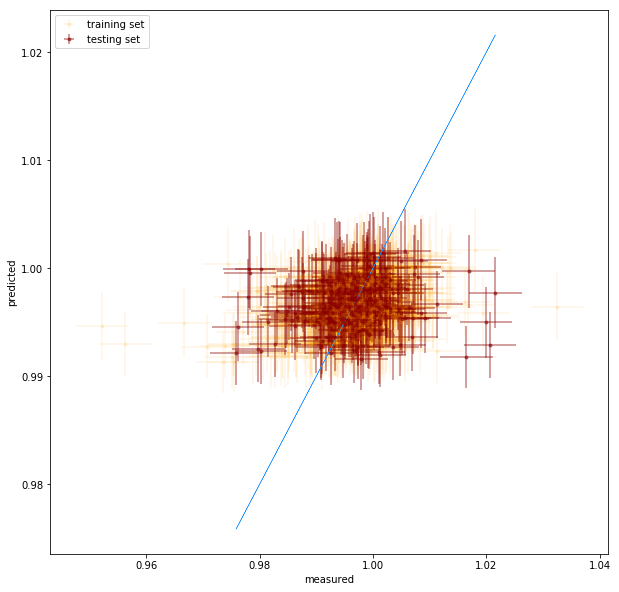

In [76]:
fig = plt.subplots(figsize=[10, 10])
linetr = plt.errorbar(br_tr, pred_tr, xerr=np.full(br_tr.shape, berr), 
                      yerr=pred_tr_err, fmt='.', color="orange", alpha=0.1)
linete = plt.errorbar(br_te, pred_te, xerr=np.full(br_te.shape, berr), 
                      yerr=pred_te_err, fmt='.', color="darkred", alpha=0.5)
linlin, = plt.plot(br_te, br_te, color="dodgerblue", lw=0.5)
plt.xlabel('measured')
plt.ylabel('predicted')
plt.legend([linetr,linete], ['training set', 'testing set'], loc='upper left')
plt.show()

#### reduced chi-squared per degree of freedom

In [77]:
def redchisqg(ydata, ymod, deg=2, sd=None):
    if np.any(sd == None):
        chisq = np.sum( (ydata-ymod)**2 )
    else:
        chisq = np.sum( ((ydata - ymod) / sd)**2 )
    
    # Number of degrees of freedom assuming 2 free parameters
    nu = ydata.size - deg
    
    return chisq/nu

In [78]:
chisq_tr_pth = redchisqg(br_tr, pred_tr, deg=ndim-1, sd=np.full(br_tr.shape, berr))
chisq_te_pth = redchisqg(br_te, pred_te, deg=ndim-1, sd=np.full(br_te.shape, berr))

print("Training chi^2/dof = {0:.3f}".format(chisq_tr_pth))
print("Testing chi^2/dof  = {0:.3f}".format(chisq_te_pth))

Training chi^2/dof = 2.280
Testing chi^2/dof  = 2.641


In [79]:
print("Delta chi^2/dof (with O3 - without O3)")
print("Training = {0:.3f}".format(chisq_tr_opth - chisq_tr_pth))
print("Testing  = {0:.3f}".format(chisq_te_opth - chisq_te_pth))

Delta chi^2/dof (with O3 - without O3)
Training = -0.105
Testing  = -0.114


# Without Temps and Humidity

In [80]:
aq_op1 = np.vstack([o3,pm25,np.ones_like(o3)]).T

In [81]:
ind  = np.arange(len(brightness))
sol  = np.linalg.lstsq(aq_op1[ind],brightness[ind], rcond=None)
pred = np.dot(aq_op1[ind],sol[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol[1] / (len(brightness) * brightness.var())
print("sol = ", sol)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([7.82658426e-02, 1.88229915e-04, 9.92342663e-01]), array([0.0560894]), 3, array([238.98473575,  16.4096876 ,   0.446111  ]))
r2  =  [0.0445071]


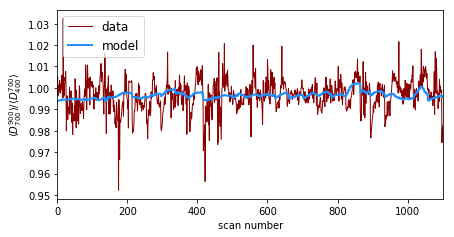

In [84]:
fig, ax = plt.subplots(figsize=[6.5,3.5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax.plot(brightness,color="darkred",lw=1)
linp, = ax.plot(pred,color="dodgerblue",lw=2)
#ax.set_ylim(-0.5,0.5)
ax.set_xlim(0,pred.size)
ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax.set_ylabel(r'$\langle D_{700}^{900} \rangle/\langle D_{400}^{700} \rangle$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

## Maximum Likelihood Estimation with NDVI

$brightness = w_{O_3} * O_3 + w_{PM2.5} * PM2.5 + b + \epsilon$

$\epsilon$ is a Gaussian noise term such that:

observed = true + random.normal(0, $\epsilon$, number_of_observations)

In [85]:
def log_prior(theta):
    beta_o3, beta_pm25, alpha, eps = theta
    if eps <= 0:
        return -np.inf
    return 0.0

def log_likelihood(theta, o3, pm25, y):
    beta_o3, beta_pm25, alpha, eps = theta
    model = beta_o3 * o3 + beta_pm25 * pm25 + alpha
    denom = eps ** 2
    lp = -0.5 * sum(((y - model) ** 2) / denom + np.log(denom) + np.log(2 * np.pi))
    return lp

def log_probability(theta, o3, pm25, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, o3, pm25, y)

In [87]:
# -- numerical optimum of likelihood function

from scipy.optimize import minimize

np.random.seed(314)
nll = lambda *args: -log_likelihood(*args)
initial = np.append(sol[0], berr)
result = minimize(nll, initial, args=(aq_op1[:,0], aq_op1[:,1], brightness))
beta_o3_ml, beta_pm25_ml, alpha_ml, epsilon_ml = result.x

print("Maximum likelihood estimates:")
print("w_o3   = {0:.5f}".format(beta_o3_ml))
print("w_pm25 = {0:.5f}".format(beta_pm25_ml))
print("b      = {0:.5f}".format(alpha_ml))
print("e      = {0:.5f}".format(epsilon_ml))

Maximum likelihood estimates:
w_o3   = 0.07827
w_pm25 = 0.00019
b      = 0.99234
e      = 0.00713


#### split sample into 80% training and 20% testing

In [88]:
from sklearn.model_selection import train_test_split

aq_tr, aq_te, br_tr, br_te = train_test_split(aq_op1, brightness, test_size=0.2, random_state=314)

In [89]:
print("total # of instances: ", len(brightness))
print("# training instances: ", len(br_tr))
print("# testing instances : ", len(br_te))
print("# features (incl. 1): ", aq_tr.shape[1])

total # of instances:  1102
# training instances:  881
# testing instances :  221
# features (incl. 1):  3


## MCMC

$brightness = w_{O_3} * O_3 + w_{PM2.5} * PM2.5 + b + \epsilon$

$\epsilon$ is Gaussian noise term such that:

brightness observed = true brightness + random.normal(0, $\epsilon$, number_of_observations)

In [90]:
nwalkers, ndim = 50, 4
p0 = result.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [91]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(aq_tr[:,0],
                                                              aq_tr[:,1],
                                                              br_tr))
pos, prob, state = sampler.run_mcmc(p0, 5000)

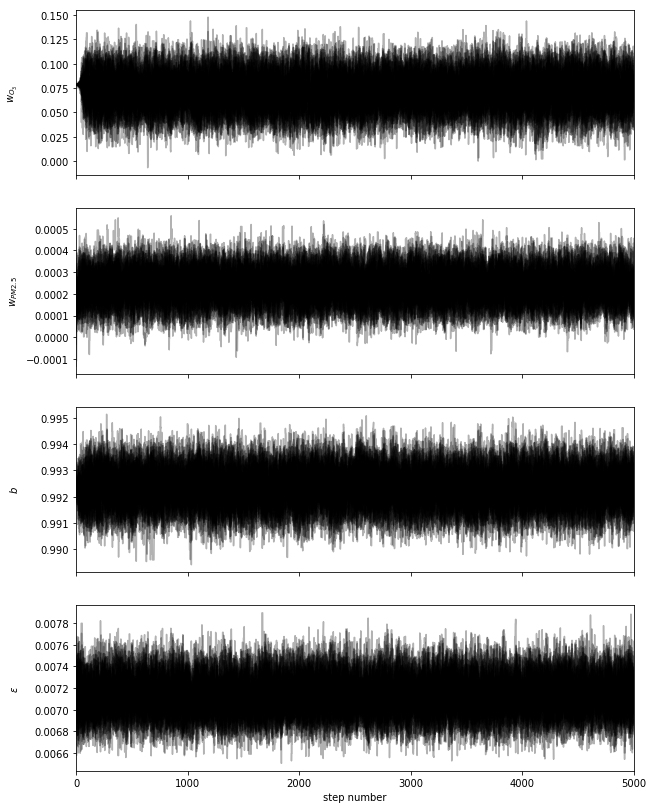

In [92]:
fig, axes = plt.subplots(ndim, figsize=(10, 14), sharex=True)
samples = sampler.get_chain()
labels = [r'$w_{O_3}$', r'$w_{PM2.5}$', r'$b$', r'$\epsilon$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number")
plt.show()

In [93]:
tau = sampler.get_autocorr_time()
print(tau)

[46.14860901 47.43945162 44.49879544 42.36874133]


In [94]:
# -- discard initial 135 steps (~3 x tau)
# -- thin by 20 (about half the autocorrelation time)
# -- flatten chain

flat_samples = sampler.get_chain(discard=135, thin=20, flat=True)
print(flat_samples.shape)

(12150, 4)


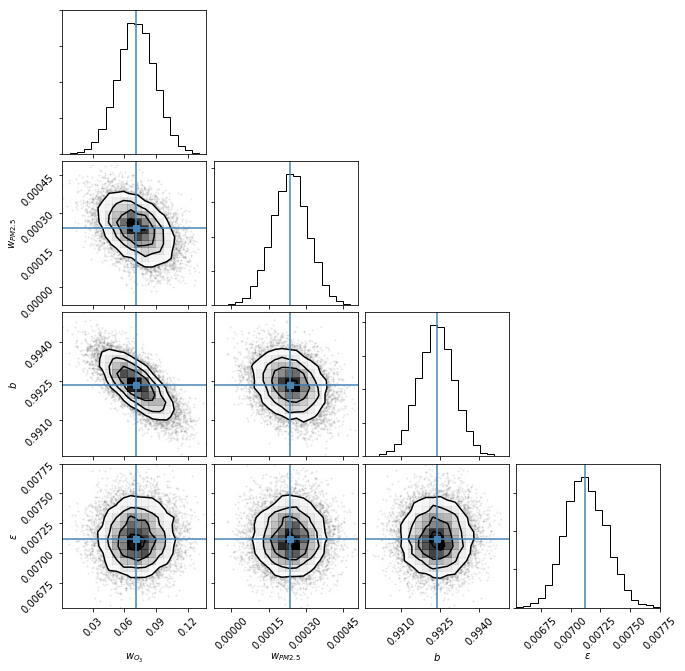

In [95]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=np.median(flat_samples, axis=0))

In [96]:
from IPython.display import display, Math

labels = ["w_{O_3}", "w_{PM2.5}", "b", "\epsilon"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

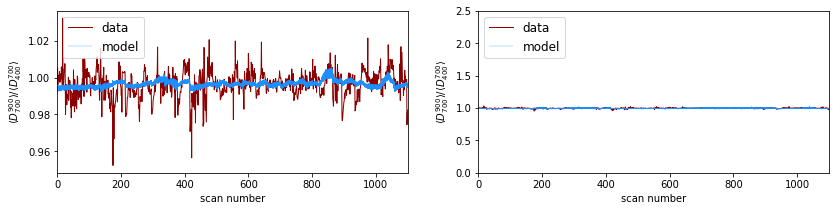

In [99]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=[13,3])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax1.plot(brightness,color="darkred",lw=1)
inds = np.random.randint(len(flat_samples), size=800)
for ind in inds:
    sample = flat_samples[ind]
    linp, = ax1.plot(np.dot(aq_op1, sample[:3]), color="dodgerblue", lw=0.3)
#ax1.set_ylim(-0.5,0.5)
ax1.set_xlim(0,pred.size)
ax1.set_xlabel("scan number")
ax1.set_ylabel(r'$\langle D_{700}^{900} \rangle/\langle D_{400}^{700} \rangle$')
ax1.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)

linb, = ax2.plot(brightness,color="darkred",lw=1)
inds = np.random.randint(len(flat_samples), size=800)
for ind in inds:
    sample = flat_samples[ind]
    linp, = ax2.plot(np.dot(aq_op1, sample[:3]), color="dodgerblue", lw=0.3)
ax2.set_ylim(0,2.5)
ax2.set_xlim(0,pred.size)
ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$\langle D_{700}^{900} \rangle/\langle D_{400}^{700} \rangle$')
ax2.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

In [100]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals = np.zeros(4)
err_vals = np.zeros(4)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals[i] = mcmc[1]
    err_vals[i] = (abs(q[0]) + abs(q[1])) / 2

print(mvals)
print(err_vals)

[7.13075198e-02 2.37635403e-04 9.92355886e-01 7.12147245e-03]
[1.77928567e-02 7.24484449e-05 6.88311642e-04 1.68887803e-04]


In [101]:
# calculate prediction and uncertainty
pred_tr = np.dot(aq_tr, mvals[:3])
pred_te = np.dot(aq_te, mvals[:3])
pred_tr_err = np.zeros(pred_tr.shape)
pred_te_err = np.zeros(pred_te.shape)

def err_mult(m, merr, x, xerr):
    err = abs(m * x) * np.sqrt((merr/m)**2 + (xerr/x)**2)
    return err

for i in range(aq_tr.shape[0]):
    mO_err = err_mult(mvals[0], err_vals[0], aq_tr[i,0], air_err[0])
    mp_err = err_mult(mvals[1], err_vals[1], aq_tr[i,1], air_err[1])
    pred_tr_err[i] = np.linalg.norm(np.array([mO_err, mp_err, err_vals[2]]))

for i in range(aq_te.shape[0]):
    mO_err = err_mult(mvals[0], err_vals[0], aq_te[i,0], air_err[0])
    mp_err = err_mult(mvals[1], err_vals[1], aq_te[i,1], air_err[1])
    pred_te_err[i] = np.linalg.norm(np.array([mO_err, mp_err, err_vals[2]]))

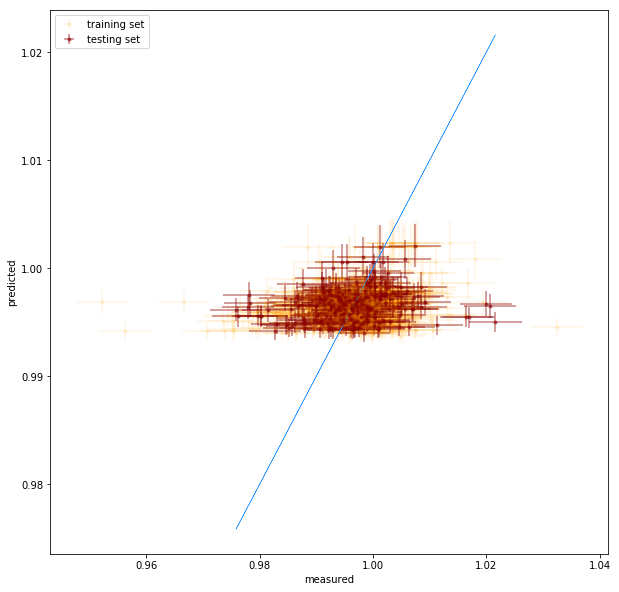

In [102]:
fig = plt.subplots(figsize=[10, 10])
linetr = plt.errorbar(br_tr, pred_tr, xerr=np.full(br_tr.shape, berr), 
                      yerr=pred_tr_err, fmt='.', color="orange", alpha=0.1)
linete = plt.errorbar(br_te, pred_te, xerr=np.full(br_te.shape, berr), 
                      yerr=pred_te_err, fmt='.', color="darkred", alpha=0.5)
linlin, = plt.plot(br_te, br_te, color="dodgerblue", lw=0.5)
plt.xlabel('measured')
plt.ylabel('predicted')
plt.legend([linetr,linete], ['training set', 'testing set'], loc='upper left')
plt.show()

#### reduced chi-squared per degree of freedom

In [103]:
def redchisqg(ydata, ymod, deg=2, sd=None):
    if np.any(sd == None):
        chisq = np.sum( (ydata-ymod)**2 )
    else:
        chisq = np.sum( ((ydata - ymod) / sd)**2 )
    
    # Number of degrees of freedom assuming 2 free parameters
    nu = ydata.size - deg
    
    return chisq/nu

In [104]:
chisq_tr_op = redchisqg(br_tr, pred_tr, deg=ndim-1, sd=np.full(br_tr.shape, berr))
chisq_te_op = redchisqg(br_te, pred_te, deg=ndim-1, sd=np.full(br_te.shape, berr))

print("Training chi^2/dof = {0:.3f}".format(chisq_tr_op))
print("Testing chi^2/dof  = {0:.3f}".format(chisq_te_op))

Training chi^2/dof = 2.377
Testing chi^2/dof  = 2.491


In [105]:
print("Delta chi^2/dof (with T&H - without T&H)")
print("Training = {0:.3f}".format(chisq_tr_opth - chisq_tr_op))
print("Testing  = {0:.3f}".format(chisq_te_opth - chisq_te_op))

Delta chi^2/dof (with T&H - without T&H)
Training = -0.203
Testing  = 0.036
